In [1]:
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Dense, concatenate
from tensorflow.keras.models import Model
from keras.callbacks import History 
from sklearn.utils import shuffle
from sklearn.preprocessing import RobustScaler, PowerTransformer
from tensorflow.keras import regularizers
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import itertools

history = History()
from keras.callbacks import Callback

#Rank Gauss is a simple way to rescale data to fit with NN requierements that
#is working quite well
def rank_gauss(x):
    from scipy.special import erfinv
    N = x.shape[0]
    temp = x.argsort()
    rank_x = temp.argsort() / N
    rank_x -= rank_x.mean()
    rank_x *= 2
    efi_x = erfinv(rank_x)
    efi_x -= efi_x.mean()
    return efi_x

#I am using the sklearn method to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Using TensorFlow backend.


# Introduction

The purpose of this challenge is to predict the similarity between two pictures that have been pre-processed through an algorithm that identify key caracteristics and scores between thoses pictures.

Our training dataset has around 3 millions samples. The different features are :

fA1 to fA14 : caracteristics of picture A

fB1 to fB14 : caracteristics of picture B

s1 to s8 : matching scores between image A and image B calculated from unknown functions.

In [0]:
xtrain = pd.read_csv('https://www.dropbox.com/s/myvvtmw61eg5gk7/xtrain_challenge.csv?dl=1')
xtest = pd.read_csv('https://www.dropbox.com/s/bfrx8b4mqythm4q/xtest_challenge.csv?dl=1')
ytrain = pd.read_csv('https://www.dropbox.com/s/cleumxob0dfzre4/ytrain_challenge.csv?dl=1')
ytrain = np.array(ytrain).reshape(len(ytrain))

# Data Structure

### Global description

In [0]:
print(xtrain.head())

xtrain.describe()

    fA1   fA2  fA3  fA4  fA5  fA6  fA7   fA8   fA9  fA10   ...    fB13  \
0  3.77  1.00  1.0   41  1.0  0.0  0.0 -0.17  0.03  0.00   ...    0.04   
1  1.47  0.01  0.0   62  1.0  0.0  0.0  0.30  0.02 -0.01   ...    0.01   
2  4.93  1.00  0.0   21  1.0  0.0  0.0  0.00  0.16  0.00   ...    0.07   
3  3.89  1.00  0.0   20  1.0  0.0  0.0 -0.35  0.09 -0.01   ...    0.10   
4  3.15  0.00  0.0   28  1.0  0.0  0.0  0.08 -0.08 -0.01   ...    0.01   

     fB14      s1      s2      s3      s4      s5      s6      s7      s8  
0  271.80  2464.1  2117.2  1760.6  2241.3  1900.3  1462.8  2344.9  1949.8  
1  157.15  3975.9  2640.9  2672.6  4233.8  3357.9  2224.0  3341.1  3611.5  
2  283.33  3401.1  2644.3  2514.2  3551.3  3019.7  3414.7  2763.6  3252.2  
3  298.40  2418.6  2659.6  2742.1  3422.4  2602.6  2784.0  2697.4  2505.1  
4  248.69  2309.1  2164.0  1755.6  2377.4  1994.6  2147.6  1902.9  2599.5  

[5 rows x 36 columns]


,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB13,fB14,s1,s2,s3,s4,s5,s6,s7,s8
count,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,...,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06,3.196465e+06
mean,3.123656e+00,7.200140e-01,8.895844e-02,2.938227e+01,9.112188e-01,4.165448e-03,8.456615e-02,1.323673e-01,2.970159e-02,-2.833317e-04,...,-4.888641e-03,2.477718e+02,3.874350e+03,2.434998e+03,4.200151e+03,4.242067e+03,3.488791e+03,3.399066e+03,3.509614e+03,3.745971e+03
std,1.618458e+00,4.224322e-01,2.824698e-01,9.793075e+00,2.757797e-01,4.433567e-02,2.729676e-01,4.159110e-01,1.279389e-01,2.096133e-02,...,5.770911e-02,1.221232e+02,2.063822e+03,2.272729e+02,2.954367e+03,2.127659e+03,1.360081e+03,1.363354e+03,1.066627e+03,1.548290e+03
min,-4.500000e-01,0.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-2.550000e+00,-3.030000e+00,-3.000000e-01,...,-4.200000e-01,-3.087900e+02,1.212700e+03,1.511400e+03,7.218000e+02,1.133800e+03,6.682000e+02,7.200000e+02,1.358000e+03,7.107000e+02
25%,1.950000e+00,2.500000e-01,0.000000e+00,2.200000e+01,1.000000e+00,0.000000e+00,0.000000e+00,-2.000000e-02,-2.000000e-02,0.000000e+00,...,-3.000000e-02,2.214200e+02,2.420300e+03,2.296300e+03,2.086200e+03,2.735400e+03,2.457200e+03,2.335000e+03,2.742600e+03,2.620100e+03
50%,3.390000e+00,1.000000e+00,0.000000e+00,2.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e-02,0.000000e+00,...,0.000000e+00,2.766400e+02,3.062600e+03,2.439800e+03,3.073300e+03,3.402000e+03,3.063300e+03,2.999800e+03,3.151800e+03,3.218800e+03
75%,4.380000e+00,1.000000e+00,0.000000e+00,3.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e-01,8.000000e-02,1.000000e-02,...,2.000000e-02,3.216600e+02,4.442500e+03,2.589300e+03,5.143800e+03,4.898800e+03,4.406800e+03,4.375500e+03,3.926300e+03,4.396900e+03
max,7.940000e+00,1.000000e+00,1.000000e+00,7.400000e+01,1.000000e+00,1.000000e+00,1.000000e+00,2.500000e+00,7.600000e-01,2.600000e-01,...,4.400000e-01,4.814200e+02,1.204420e+04,3.035900e+03,1.666650e+04,1.181290e+04,7.731000e+03,7.580100e+03,6.949500e+03,8.524900e+03


### Unique elements per feature

In [0]:
for c in xtrain.columns:
    print(f'{c} : {len(xtrain[c].unique())} unique elements')

fA1 : 743 unique elements
fA2 : 101 unique elements
fA3 : 101 unique elements
fA4 : 57 unique elements
fA5 : 101 unique elements
fA6 : 101 unique elements
fA7 : 101 unique elements
fA8 : 397 unique elements
fA9 : 237 unique elements
fA10 : 54 unique elements
fA11 : 100 unique elements
fA12 : 96 unique elements
fA13 : 81 unique elements
fA14 : 33131 unique elements
fB1 : 739 unique elements
fB2 : 101 unique elements
fB3 : 101 unique elements
fB4 : 56 unique elements
fB5 : 101 unique elements
fB6 : 100 unique elements
fB7 : 96 unique elements
fB8 : 389 unique elements
fB9 : 164 unique elements
fB10 : 53 unique elements
fB11 : 69 unique elements
fB12 : 96 unique elements
fB13 : 67 unique elements
fB14 : 29338 unique elements
s1 : 90745 unique elements
s2 : 13705 unique elements
s3 : 133754 unique elements
s4 : 91052 unique elements
s5 : 59419 unique elements
s6 : 60635 unique elements
s7 : 48002 unique elements
s8 : 68042 unique elements


In [0]:
len(xtrain[['fB'+str(i) for i in range(1,15)]].drop_duplicates())

62459

Something really interesting is the number of unique features for the columns FA1 to fA13 and FB1 to FB13. 
Looking also at their distribution, we might consider them as categorical feature during the feature engineer phase

### Distribution of the features

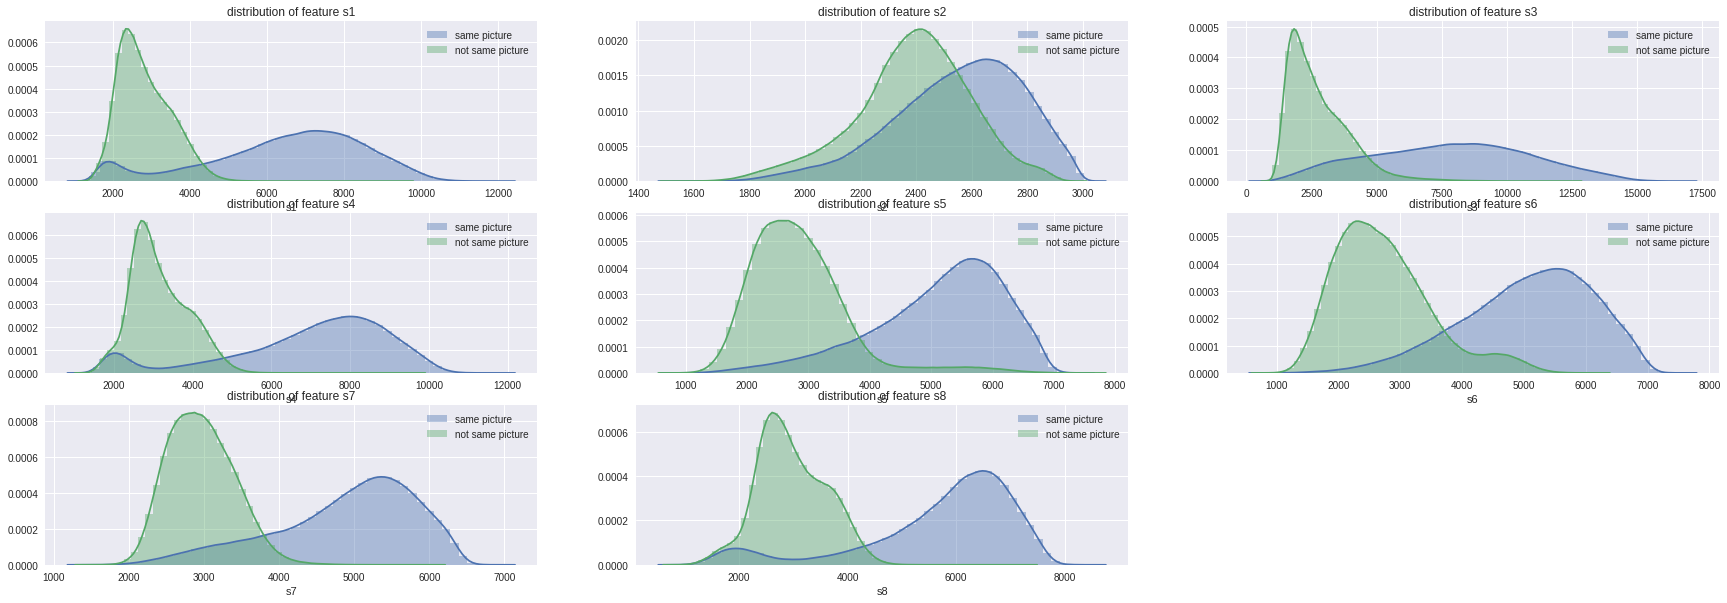

In [0]:
plt.figure(figsize=(30,10))
for i in range(1,9):
    feature = 's'+str(i)

    plt.subplot(3,3,i)
    sns.distplot(xtrain[[feature]].iloc[np.where(ytrain==1)],label = 'same picture')
    sns.distplot(xtrain[[feature]].iloc[np.where(ytrain==0)], label = 'not same picture')
    plt.title(f'distribution of feature {feature}')
    plt.xlabel(feature)
    plt.legend()

We can see thats scores are very good descriminative feature between label 0 and label 1.
Nevertheless, the non-standard repartition  might make it difficult to rescale to a simple gaussian distribution

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


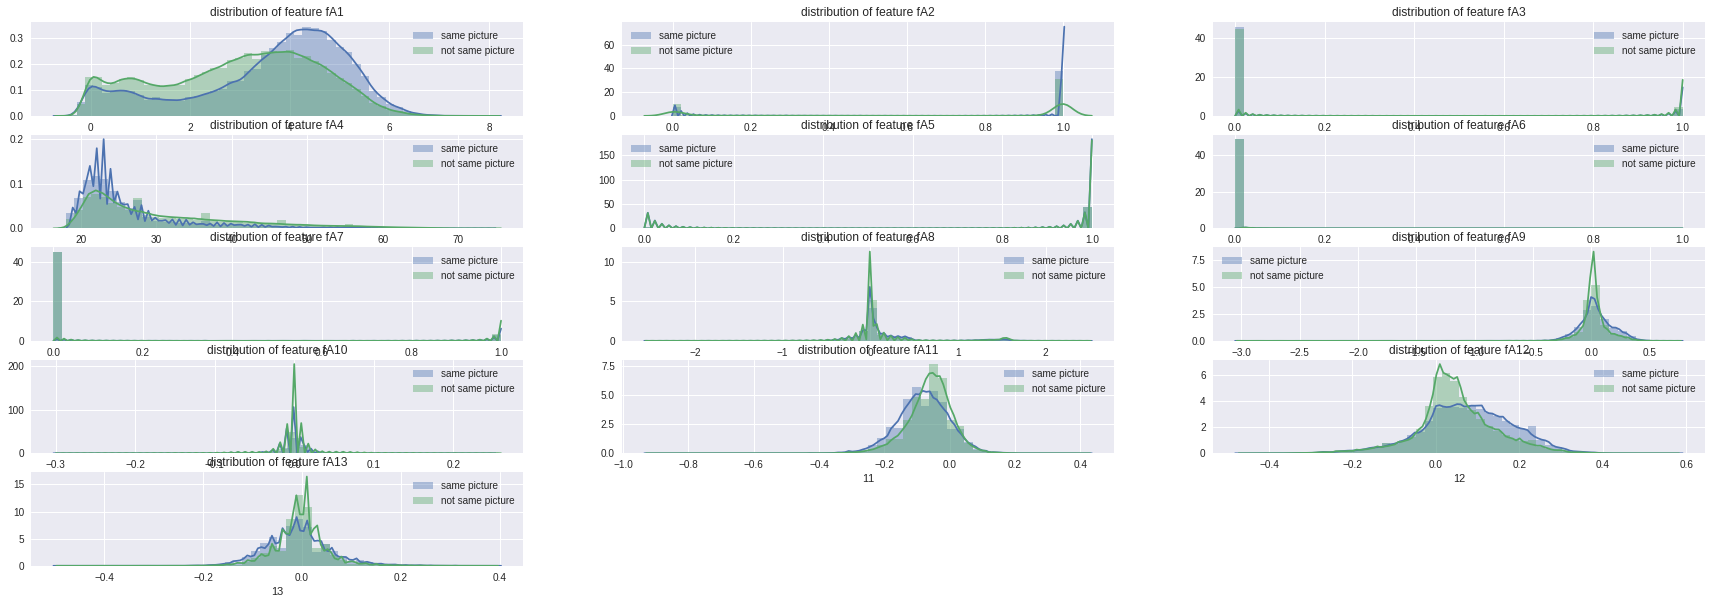

In [13]:
plt.figure(figsize=(30,10))
for i in range(1,14):
    featureA = 'fA'+str(i)
    featureB = 'fA'+str(i)

    plt.subplot(5,3,i)
    sns.distplot(xtrain[[featureA]].iloc[np.where(ytrain==1)],label = 'same picture')
    sns.distplot(xtrain[[featureA]].iloc[np.where(ytrain==0)], label = 'not same picture')
    plt.title(f'distribution of feature {featureA}')
    plt.xlabel(i)
    plt.legend()

### Distribution of the labels

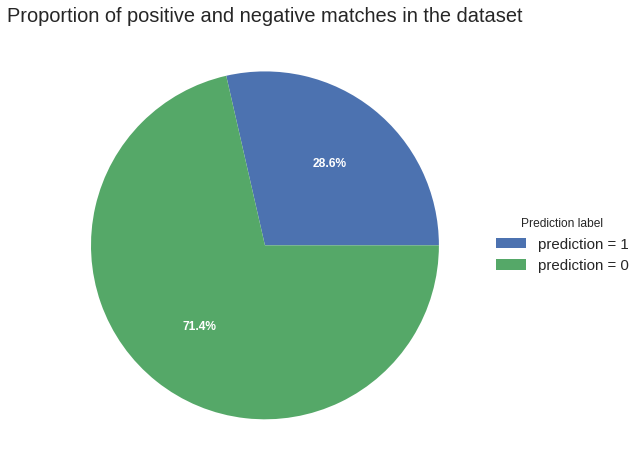

In [0]:
#Let's change a bit and plot a pie graph to visualise the influance of Ad size on click
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw=dict(aspect="equal"))

df1 = len(xtrain.iloc[np.where(ytrain==1)])
df2 = len(xtrain.iloc[np.where(ytrain==0)])


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)

wedges, texts, autotexts = ax.pie([df1,df2], autopct=lambda pct: func(pct, [df1,df2]),
                                  textprops=dict(color="w"))

ax.legend(wedges, ['prediction = 1','prediction = 0'],
          title="Prediction label",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          prop={'size': 15})

plt.setp(autotexts, size=12, weight="bold")
plt.title("Proportion of positive and negative matches in the dataset", size=20)
plt.setp(texts, size=20, weight="bold")
plt.show()

There is approximatively 1/3 of the data that are tagged with label 1, and 2/3 with label 0. 

# First ML model and use of Boosting Algorithm

The boosting method are often really relevant for structured data like the one with have.
XGBoost in particular has been very succesfull for this kind of task.

During my researches, I discovered a new algorithm that seems to perform faster than XGBoost, called LightGBM. I decided to use this last one, as it is performing much faster than XGBoost on large datasets.

Looking at the high amoung of data, we will use 95% of them for training and only 5% of them for test

In [3]:
from lightgbm import LGBMClassifier

ntrain = int(0.95*len(xtrain))
x_, y_ = shuffle(xtrain,ytrain)
Xtrain, Ytrain = x_[:ntrain], y_[:ntrain]
Xtest, Ytest = x_[ntrain:], y_[ntrain:]
lgb = LGBMClassifier(num_leaves = 2000, 
                     n_estimators = 500, 
                     learning_rate = 0.05).fit(Xtrain, Ytrain)
score_lgb = lgb.score(Xtest,Ytest)

print(f'score of the lgb model : {round(score_lgb,4)}')

score of the lgb model : 0.9934


Lets also check the confusion matrix

Normalized confusion matrix
[[0.9924 0.0076]
 [0.004  0.996 ]]


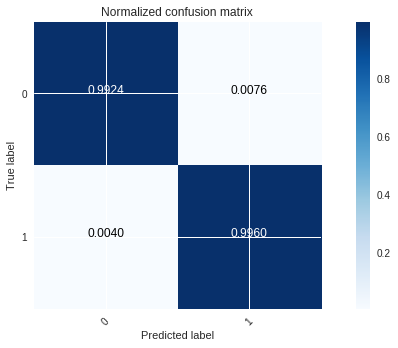

In [4]:
from sklearn.metrics import confusion_matrix
import itertools
# Compute confusion matrix
cnf_matrix = confusion_matrix(lgb.predict(Xtest), Ytest)
np.set_printoptions(precision=4)

plt.figure(figsize = (10,5))
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Uses of Neural Networks

Given the very high amount of data available, I was wondering if a deep-learning algorithm could perform better that the classic boosting algorithms. 

I initiated this study with the aim of doing at least as well as with a Boosting Algorithm, thus my target was 99.4% of correct prediction.

In order to do the design of the following networks, I will be using Keras and Tensorflow.

I am also using Google Colab in order to have acces to the GPU calculation



### Feature Engineering

Working with Neural Networks requiere nice scaled data in order to stay within the ranges of activation during gradient descent.

One of the way to rescale of the data that I found was to apply a Rank Gauss transformation to the data, see code bellow :

In [0]:
def rank_gauss(x):
    from scipy.special import erfinv
    N = x.shape[0]
    temp = x.argsort()
    rank_x = temp.argsort() / N
    rank_x -= rank_x.mean()
    rank_x *= 2
    efi_x = erfinv(rank_x)
    efi_x -= efi_x.mean()
    return efi_x


ntrain = int(0.95*len(xtrain))
x_, y_ = shuffle(xtrain,ytrain)

for i in xtrain.columns:
    x_[i] = rank_gauss(x_[i].values)
    

Xtrain, Ytrain = x_[:ntrain], y_[:ntrain]
Xtest, Ytest = x_[ntrain:], y_[ntrain:]

### I. Classic Neural Network without regulation

![alt text](https://i.imgur.com/4fltz9V.png)




In [0]:
# This returns a tensor
inputs = Input(shape=(len(Xtrain.columns),), name = 'All_Inputs')

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(5000, activation='relu', name = 'Dense_Layer_ReLu')(inputs)
predictions = Dense(1, activation='sigmoid',name = 'Sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(Xtrain, Ytrain, epochs=20, batch_size=4096, validation_data=(Xtest, Ytest), callbacks=[history])

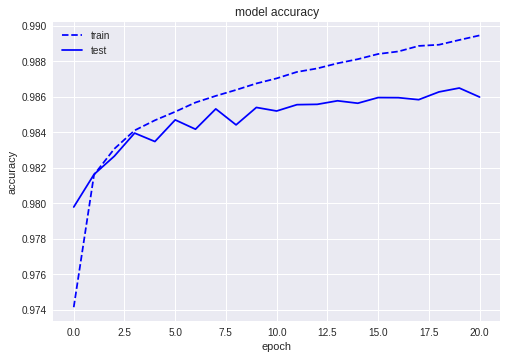

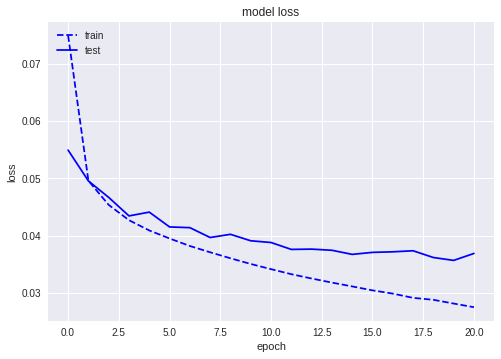

In [0]:
plt.plot(history.history['acc'],color = 'blue', linestyle = '--')
plt.plot(history.history['val_acc'], color = 'blue')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history.history['loss'],color = 'blue', linestyle = '--')
plt.plot(history.history['val_loss'], color = 'blue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

pd.DataFrame(history.history).to_csv('model1.csv')

Comment to be done

###  II. Classic Neural Network with regulation

We take same model, but add a layer of regulation to it.

![alt text](https://i.imgur.com/vnJrSvd.png)

In [0]:
# This returns a tensor
inputs = Input(shape=(len(Xtrain.columns),), name = 'All_Inputs')

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(5000, activation='relu', name = 'Dense_Layer_ReLu_1')(inputs)
x = keras.layers.BatchNormalization(name = 'Normalisation_Layer_1')(x)
predictions = Dense(1, activation='sigmoid',name = 'Sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(Xtrain, Ytrain, epochs=20, batch_size=4096, validation_data=(Xtest, Ytest), callbacks=[history])

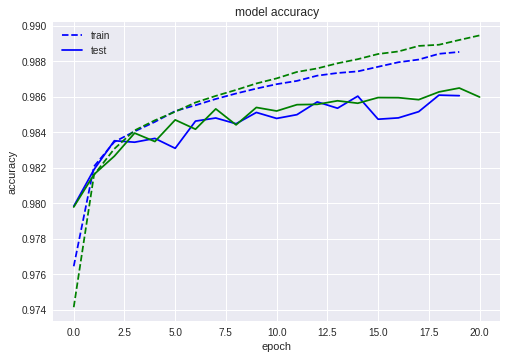

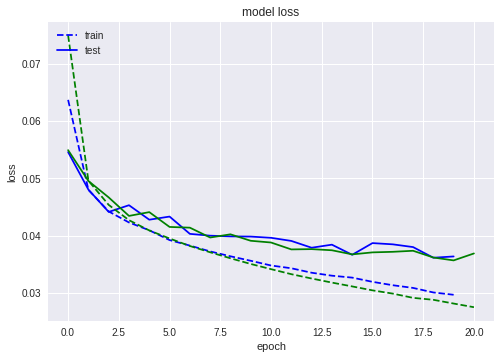

In [0]:
history1 = pd.read_csv('model1.csv')
plt.plot(history.history['acc'],color = 'blue', linestyle = '--')
plt.plot(history.history['val_acc'], color = 'blue')
plt.plot(history1['acc'],color = 'green', linestyle = '--')
plt.plot(history1['val_acc'], color = 'green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history.history['loss'],color = 'blue', linestyle = '--')
plt.plot(history.history['val_loss'], color = 'blue')
plt.plot(history1['loss'],color = 'green', linestyle = '--')
plt.plot(history1['val_loss'], color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

pd.DataFrame(history.history).to_csv('model1.csv')

We can see that appart from slowing down the calculation, the regulation doesn't seem to improve the model for now.
The overfitting is already limited due to the very large amount of data.

### III. A deeper network

We try now to increase the number of layer of the Neural Network

In [0]:
# This returns a tensor
inputs = Input(shape=(len(Xtrain.columns),), name = 'All_Inputs')

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(4096, activation='relu', name = 'Dense_Layer_ReLu_1')(inputs)
x = Dense(1024, activation='relu', name = 'Dense_Layer_ReLu_2')(x)
x = Dense(248, activation='relu', name = 'Dense_Layer_ReLu_3')(x)
x = Dense(64, activation='relu', name = 'Dense_Layer_ReLu_4')(x)

predictions = Dense(1, activation='sigmoid',name = 'Sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(Xtrain, Ytrain, epochs=20, batch_size=4096, validation_data=(Xtest, Ytest), callbacks=[history])

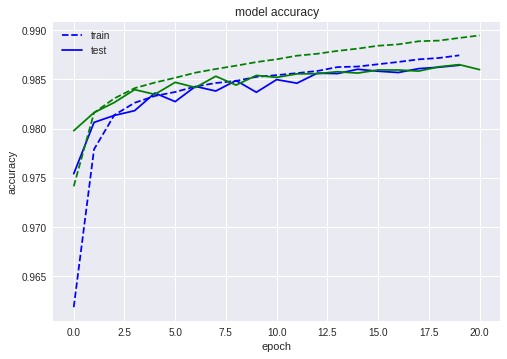

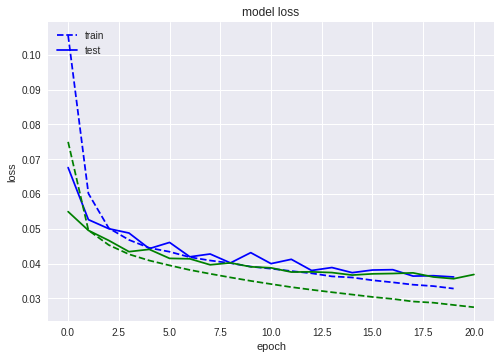

In [0]:
history1 = pd.read_csv('model1.csv')
plt.plot(history.history['acc'],color = 'blue', linestyle = '--')
plt.plot(history.history['val_acc'], color = 'blue')
plt.plot(history1['acc'],color = 'green', linestyle = '--')
plt.plot(history1['val_acc'], color = 'green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history.history['loss'],color = 'blue', linestyle = '--')
plt.plot(history.history['val_loss'], color = 'blue')
plt.plot(history1['loss'],color = 'green', linestyle = '--')
plt.plot(history1['val_loss'], color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

pd.DataFrame(history.history).to_csv('model3.csv')

We can see here that increasing the number of layer is not improving significantly our score. We have to find another way to improve the model.

### IV. Using one hot encoding on some features

We saw before that the columns fA1 to fA13 and fB1 to fB13 could be treated as categorical feature.
In order to proceed we will use the OneHotEncoder from sklearn and use the new table generated as the input for our Neural Network

![alt text](https://i.imgur.com/C2GDowW.png)

In [0]:
ntrain = int(0.95*len(xtrain))
x_, y_ = shuffle(xtrain,ytrain)

#This time we rescale only features scores and fA14 and fB14
for i in ['s'+str(i) for i in range(1,9)]:
    x_[i] = rank_gauss(x_[i].values)

x_['fA14'] = rank_gauss(x_['fA14'].values)
x_['fB14'] = rank_gauss(x_['fB14'].values)

ohe = OneHotEncoder(categories='auto')
#We generate the list of features to be ohe
list_feats = ['fA'+str(i) for i in range(1,14)] + ['fB'+str(i) for i in range(1,14)]

#We first split train and set, and we then ohe both of them
Xtrain, Ytrain = x_[:ntrain], y_[:ntrain]
Xtest, Ytest = x_[ntrain:], y_[ntrain:]

ohe.fit(x_[list_feats])
Xtrain_ohe = ohe.transform(Xtrain[list_feats])
Xtest_ohe = ohe.transform(Xtest[list_feats])

Xtrain_other = Xtrain.drop(list_feats,axis=1)
Xtest_other = Xtest.drop(list_feats,axis=1)

There is a big reason why we don't merge back the ohe features with the others. The ohe features are compressed by OneHotEncoder, but if we merge them to the rest of our data, they will be uncompressed that will take a lot of memory and slower the calculation.

We will use the option of Keras to concatenate the feature directly inside the Neural Network for the calculation.

In [0]:
# We create the tensors for the input
inputs_ohe = Input(shape=(Xtrain_ohe.shape[1],), name = 'Ohe_inputs')
inputs_other = Input(shape=(len(Xtrain_other.columns),), name = 'Other_inputs')

#List of both inputs for the concatenation and compilation
input_list = [inputs_ohe,inputs_other]

inputs = concatenate(input_list)
# a layer instance is callable on a tensor, and returns a tensor
x = Dense(1024, activation='relu', name = 'Dense_Layer_ReLu_1')(inputs)

predictions = Dense(1, activation='sigmoid',name = 'Sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=input_list, outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Xtrain_inputs = [Xtrain_ohe,Xtrain_other]
Xtest_inputs = [Xtest_ohe,Xtest_other]
model.fit(Xtrain_inputs, Ytrain, epochs=10, batch_size=4096, validation_data=(Xtest_inputs, Ytest), callbacks=[history])

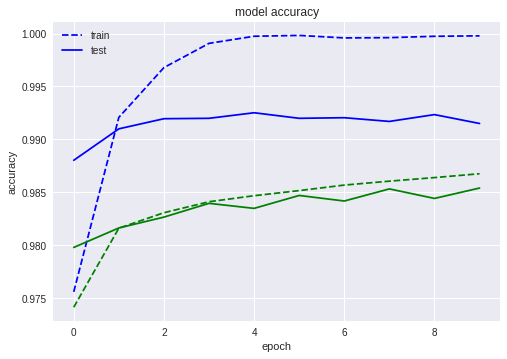

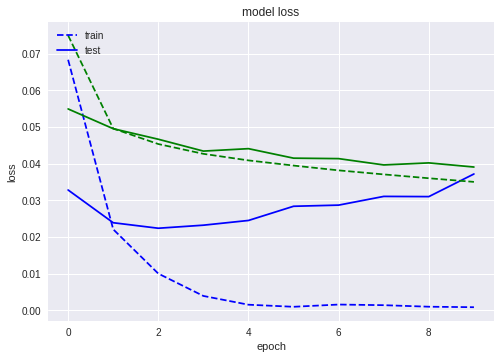

In [0]:
pd.DataFrame(history.history).to_csv('model5.csv')

history5 = pd.read_csv('model1.csv')
history4 = pd.read_csv('model3.csv')
plt.plot(history4['acc'],color = 'blue', linestyle = '--')
plt.plot(history4['val_acc'], color = 'blue')
plt.plot(history5['acc'][:10],color = 'green', linestyle = '--')
plt.plot(history5['val_acc'][:10], color = 'green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss

plt.plot(history4['loss'],color = 'blue', linestyle = '--')
plt.plot(history4['val_loss'], color = 'blue')
plt.plot(history5['loss'][:10],color = 'green', linestyle = '--')
plt.plot(history5['val_loss'][:10], color = 'green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


We can see that the OneHotEncoding of the categorical feature is helping a lot our model. The level of error of our predictor dropped by almost 50% compared to our first neural network approach.

Another notable point is that the training data is  minimizing much faster the loss than before. 

My feeling at that point is that we are not exploiting enough all the data inside the training set to fit better the curve.



### V. Trying more complex architectures

Arrived at that point, I understood that I had to rearange more deeply the architecture of my Neural Network in order to improve its performances. 

2 models came into my mind that I will try here :

    a)  Adding an extra layer that compare the image to each score

    b)  Adding an extra layer comparing each Img to the scores

I will compute below these two models.
#### Modèle a)
![alt text](https://i.imgur.com/a54zdt6.png)

#### Modèle b)
![alt text](https://i.imgur.com/E6xCSLN.png)


### Model 5a : A Neural Network with intermediate layer for each score

In [0]:
ntrain = int(0.95*len(xtrain))
x_, y_ = shuffle(xtrain,ytrain)

#This time we rescale only features scores and fA14 and fB14
for i in ['s'+str(i) for i in range(1,9)]:
    x_[i] = rank_gauss(x_[i].values)

x_['fA14'] = rank_gauss(x_['fA14'].values)
x_['fB14'] = rank_gauss(x_['fB14'].values)

ohe = OneHotEncoder(categories='auto')
#We generate the list of features to be ohe
list_feats = ['fA'+str(i) for i in range(1,14)] + ['fB'+str(i) for i in range(1,14)]

#We first split train and set, and we then ohe both of them
Xtrain, Ytrain = x_[:ntrain], y_[:ntrain]
Xtest, Ytest = x_[ntrain:], y_[ntrain:]

ohe.fit(x_[list_feats])
Xtrain_ohe = ohe.transform(Xtrain[list_feats])
Xtest_ohe = ohe.transform(Xtest[list_feats])

Xtrain_14 = Xtrain[['fA14','fB14']]
Xtest_14 = Xtest[['fA14','fB14']]

Xtrain_s = [Xtrain['s'+str(i)] for i in range(1,9)]
Xtest_s = [Xtest['s'+str(i)] for i in range(1,9)]

In [0]:
# We create the tensors for the input
inputs_ohe = Input(shape=(Xtrain_ohe.shape[1],), name = 'Ohe_inputs')
inputs_14 = Input(shape=(2,), name = '14_inputs')

#List of both inputs for the concatenation and compilation 
input_list = [inputs_ohe,inputs_14]

#Concatenation of the inputs of both images
input_img = concatenate(input_list, name='Img_merge')

scores = []
#We train now 8 different layer for each score
for i in range(1,9):
    input_s = Input(shape=(1,), name = f'input_score_{i}')
    input_list.append(input_s)
    s_layer = concatenate([input_img,input_s], name = f'conc_s_{i}')
    xs = Dense(1024, activation = 'relu', name = f'Dense_{i}')(s_layer)
    xs = Dense(64, activation = 'relu', name = f'Dense_{i}')(s_layer)
    scores.append(xs)

#We concatenate now all 8 layers
xc = concatenate(scores, name = 'all_scores')
xc = Dense(64, activation = 'relu', name = f'Score_Dense')(xc)
predictions = Dense(1, activation='sigmoid',name = 'Sigmoid')(xc)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=input_list, outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Xtrain_inputs = [Xtrain_ohe,Xtrain_14] + Xtrain_s
Xtest_inputs = [Xtest_ohe,Xtest_14] + Xtest_s
model.fit(Xtrain_inputs, Ytrain, epochs=10, batch_size=4096, validation_data=(Xtest_inputs, Ytest), callbacks=[history])

In [0]:
pd.DataFrame(history.history).to_csv('model5a.csv')

### Model 5b : A Neural Network with intermediate network for each picture

In [0]:
ntrain = int(0.95*len(xtrain))
x_, y_ = shuffle(xtrain,ytrain)

#This time we rescale only features scores and fA14 and fB14
for i in ['s'+str(i) for i in range(1,9)]:
    x_[i] = rank_gauss(x_[i].values)

x_['fA14'] = rank_gauss(x_['fA14'].values)
x_['fB14'] = rank_gauss(x_['fB14'].values)

oheA = OneHotEncoder(categories='auto')
oheB = OneHotEncoder(categories='auto')

#We generate the list of features to be ohe
list_featsA = ['fA'+str(i) for i in range(1,14)]
list_featsB = ['fB'+str(i) for i in range(1,14)]

#We first split train and set, and we then ohe both of them
Xtrain, Ytrain = x_[:ntrain], y_[:ntrain]
Xtest, Ytest = x_[ntrain:], y_[ntrain:]

oheA.fit(x_[list_featsA])
oheB.fit(x_[list_featsB])


Xtrain_oheA = oheA.transform(Xtrain[list_featsA])
Xtest_oheA = oheA.transform(Xtest[list_featsA])

Xtrain_oheB = oheB.transform(Xtrain[list_featsB])
Xtest_oheB = oheB.transform(Xtest[list_featsB])

Xtrain_14A = Xtrain[['fA14']]
Xtest_14A = Xtest[['fA14']]

Xtrain_14B = Xtrain[['fB14']]
Xtest_14B = Xtest[['fB14']]

Xtrain_s = Xtrain[['s'+str(i) for i in range(1,9)]]
Xtest_s = Xtest[['s'+str(i) for i in range(1,9)]]

In [0]:
# We create the tensors for the input
inputs_oheA = Input(shape=(Xtrain_oheA.shape[1],), name = 'OheA_inputs')
inputs_oheB = Input(shape=(Xtrain_oheB.shape[1],), name = 'OheB_inputs')
inputs_14A = Input(shape=(1,), name = '14A_inputs')
inputs_14B = Input(shape=(1,), name = '14B_inputs')
input_score = Input(shape=(8,), name = 'Scores_inputs')

#List of both inputs for the concatenation and compilation 
input_list = [inputs_oheA,
              inputs_oheB,
              inputs_14A,
              inputs_14B,
              input_score]

#Concatenation of the inputs of both images
imgA = concatenate([inputs_oheA,inputs_14A], name='Img_mergeA')
imgB = concatenate([inputs_oheB,inputs_14B], name='Img_mergeB')

#We train two layers, one for each image:
sA = concatenate([imgA,input_score], name='conc_scoreA')
sB = concatenate([imgB,input_score], name='conc_scoreB')

sA = Dense(1024, activation = 'relu',name = 'Dense_sA')(sA)
sB = Dense(1024, activation = 'relu',name = 'Dense_sB')(sB)


#We concatenate now all 8 layers
xc = concatenate([sA,sB], name = 'all_scores')
xc = Dense(128, activation = 'relu', name = f'Score_Dense')(xc)
predictions = Dense(1, activation='sigmoid',name = 'Sigmoid')(xc)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=input_list, outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Xtrain_inputs = [Xtrain_oheA,
                 Xtrain_oheB,
                 Xtrain_14A,
                 Xtrain_14B] \
                + [Xtrain_s]

Xtest_inputs = [Xtest_oheA,
                 Xtest_oheB,
                 Xtest_14A,
                 Xtest_14B] \
                + [Xtest_s]
model.fit(Xtrain_inputs, Ytrain, epochs=10, batch_size=4096, validation_data=(Xtest_inputs, Ytest), callbacks=[history])

In [0]:
pd.DataFrame(history.history).to_csv('model5b.csv')

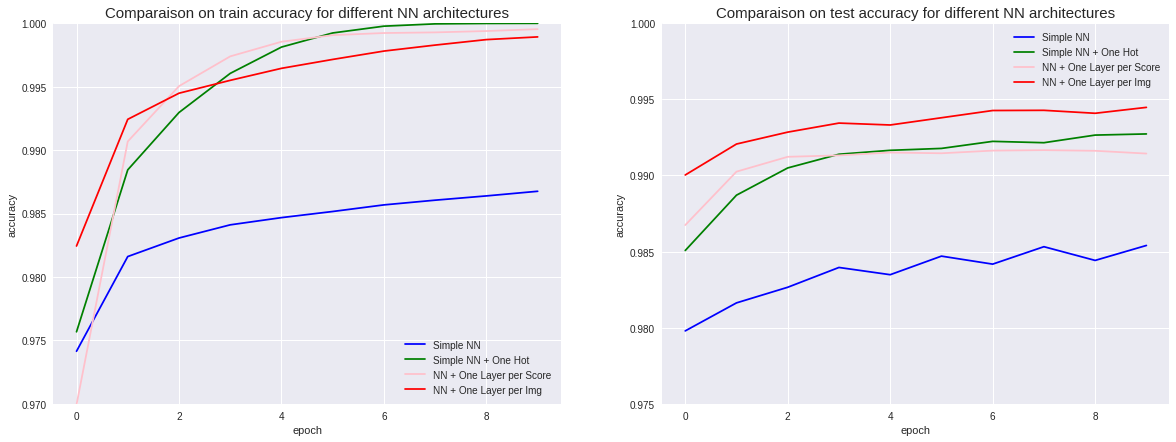

In [0]:
model1 = pd.read_csv('model1.csv')[:10]
model4 = pd.read_csv('model4.csv')
model5a = pd.read_csv('model5a.csv')
model5b = pd.read_csv('model5b.csv')

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.title('Comparaison on train accuracy for different NN architectures',size=15)
plt.plot(model1['acc'],color = 'blue', label = 'Simple NN')
plt.plot(model4['acc'],color = 'green', label = 'Simple NN + One Hot')
plt.plot(model5a['acc'],color = 'pink', label = 'NN + One Layer per Score')
plt.plot(model5b['acc'],color = 'red', label = 'NN + One Layer per Img')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.97,1])
plt.legend()


plt.subplot(1,2,2)
plt.title('Comparaison on test accuracy for different NN architectures',size=15)
plt.plot(model1['val_acc'],color = 'blue', label = 'Simple NN')
plt.plot(model4['val_acc'],color = 'green', label = 'Simple NN + One Hot')
plt.plot(model5a['val_acc'],color = 'pink', label = 'NN + One Layer per Score')
plt.plot(model5b['val_acc'],color = 'red', label = 'NN + One Layer per Img' )
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.975,1])
plt.legend()
plt.show()


The curve above are showing that using the architecture of NN + One layer per Img is improving slightly the results, reaching almost 99.5% of accuracy on the test set.

On the other hand, we are still overfitting on the trainingset a bit, and we need to find a way to balance a bit our prediction.

### Final Neural Network Model

I saw that the one hot encoding on the features for fA and fB was improving a lot my modele. The only one that I didn't one hot encoded was fA14 and fB14 because of the high amount of values in the columns.

Nevertheless, I decided to give him a try by first descretizing the values in those features before applying my Ohe on them.

Also, thanks to the last study, I saw that the model 5b was the more accurate, I then continued with him.

In order to use the more data as possible, I also feeded this time my training set with 98% of the data, using the 2 last % to monitor the precision accuracy on a brand new dataset.

Finally, as for the last prediction, I increased the number of batch and added a BatchNorm layer at the end of the network

In [0]:
from sklearn.preprocessing import KBinsDiscretizer

ntrain = int(0.98*len(xtrain))
x_, y_ = pd.concat([xtrain,xtest]), ytrain

#This time we rescale only features scores and fA14 and fB14
for i in ['s'+str(i) for i in range(1,9)]:
    x_[i] = rank_gauss(x_[i].values)

x_['fA14'] = KBinsDiscretizer(n_bins = 2000, encode = 'ordinal').fit_transform(x_[['fA14']])
x_['fB14'] = KBinsDiscretizer(n_bins = 2000, encode = 'ordinal').fit_transform(x_[['fB14']])

oheA = OneHotEncoder(categories='auto')
oheB = OneHotEncoder(categories='auto')

#We generate the list of features to be ohe
list_featsA = ['fA'+str(i) for i in range(1,15)]
list_featsB = ['fB'+str(i) for i in range(1,15)]

#We first split train and set, and we then ohe both of them
Xtrain, Ytrain = x_[:ntrain], y_[:ntrain]
Xtest, Ytest = x_[ntrain:len(xtrain)], y_[ntrain:len(xtrain)]

oheA.fit(x_[list_featsA])
oheB.fit(x_[list_featsB])


Xtrain_oheA = oheA.transform(Xtrain[list_featsA])
Xtest_oheA = oheA.transform(Xtest[list_featsA])

Xtrain_oheB = oheB.transform(Xtrain[list_featsB])
Xtest_oheB = oheB.transform(Xtest[list_featsB])

Xtrain_s = Xtrain[['s'+str(i) for i in range(1,9)]].values
Xtest_s = Xtest[['s'+str(i) for i in range(1,9)]].values

In [0]:
Xtrain_s = [Xtrain['s'+str(i)].values for i in range(1,9)]
Xtest_s = [Xtest['s'+str(i)].values for i in range(1,9)]

# We create the tensors for the input
inputs_oheA = Input(shape=(Xtrain_oheA.shape[1],), name = 'OheA_inputs')
inputs_oheB = Input(shape=(Xtrain_oheB.shape[1],), name = 'OheB_inputs')


#List of both inputs for the concatenation and compilation 
input_list = [inputs_oheA,
              inputs_oheB]

#Concatenation of the inputs of both images
imgA = inputs_oheA
imgB = inputs_oheB


scoresA = []
scoresB = []
#We train two layers, one for each image, and for each score:
for i in range(1,9):
    input_score_i = Input(shape=(1,), name = f'Scores_inputs_{i}')
    input_list.append(input_score_i)
    sA_i = concatenate([imgA,input_score_i], name=f'conc_scoreA_{i}')
    sB_i = concatenate([imgB,input_score_i], name=f'conc_scoreB_{i}')

    sA_i = Dense(512, activation = 'relu',name = f'Dense_sA_{i}')(sA_i)
    sB_i = Dense(512, activation = 'relu',name = f'Dense_sB_{i}')(sB_i)
    
    scoresA.append(sA_i)
    scoresB.append(sB_i)

sA = concatenate(scoresA)
sB = concatenate(scoresB)




#We concatenate now all 8 layers
xc = concatenate([sA,sB], name = 'all_scores')
xc = Dense(512, activation = 'relu', name = f'Score_Dense')(xc)
xc = keras.layers.BatchNormalization()(xc)
predictions = Dense(1, activation='sigmoid',name = 'Sigmoid')(xc)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=input_list, outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Xtrain_inputs = [Xtrain_oheA,
                 Xtrain_oheB] \
                + Xtrain_s

Xtest_inputs = [Xtest_oheA,
                 Xtest_oheB] \
                + Xtest_s
model.fit(Xtrain_inputs, Ytrain, epochs=50, batch_size=4096, validation_data=(Xtest_inputs, Ytest), callbacks=[history])

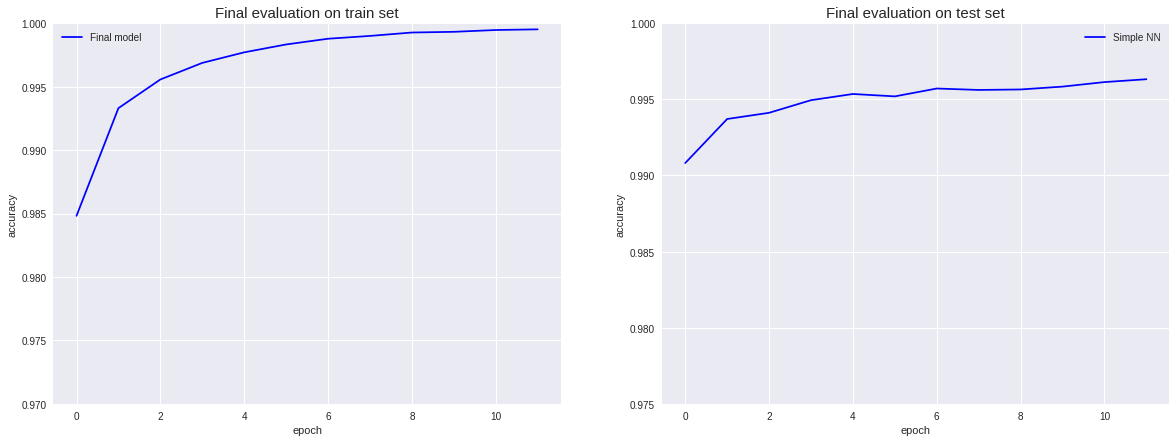

In [0]:
pd.DataFrame(history.history).to_csv('model_f.csv')

model_f = pd.DataFrame(history.history)

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.title('Final evaluation on train set',size=15)
plt.plot(model_f['acc'],color = 'blue', label = 'Final model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.97,1])
plt.legend()


plt.subplot(1,2,2)
plt.title('Final evaluation on test set',size=15)
plt.plot(model_f['val_acc'],color = 'blue', label = 'Simple NN')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.975,1])
plt.legend()
plt.show()

Normalized confusion matrix
[[0.9969 0.0031]
 [0.0049 0.9951]]


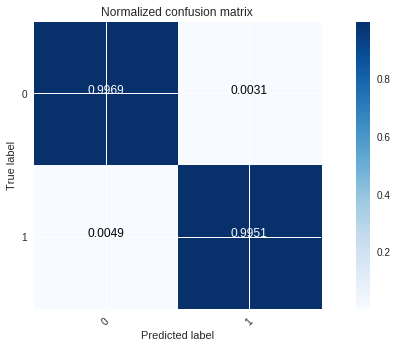

In [0]:
#Confusion matrix
y_soft = model.predict(Xtest_inputs)
y_hard = np.round(y_soft)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_hard, Ytest)
np.set_printoptions(precision=4)

plt.figure(figsize = (10,5))
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

We can see from the confusion matrice that we make very few error, both on 0 and 1 predictions. 
I stopped here after 12 epochs. But pushing the model to its limits (what I did with another training), I made a prediction score for the hidden validation set of 99.69%

In comparaison with the LGBM model, we can see that it is really the rate of false positive that we are improving

In [0]:
#We first split train and set, and we then ohe both of them
Xval = x_[len(xtrain):]

Xval_oheA = oheA.transform(Xval[list_featsA])

Xval_oheB = oheB.transform(Xval[list_featsB])

Xval_s = [Xval['s'+str(i)] for i in range(1,9)]

Xval_inputs = [Xval_oheA,
                 Xval_oheB] \
                + Xval_s

y_soft = model.predict(Xval_inputs, verbose = 1, batch_size = 10000)
y_hard = np.round(y_soft)
np.savetxt('ysoft.csv', y_soft, delimiter=',')
np.savetxt('ytest_challenge_student.csv', y_hard, fmt = '%1.0d', delimiter=',')

1598219/1598219 [==============================] - 115s 72us/step


# Conclusion ? (not yet)

### An issue in the way the data are separated

Arrived at that point, I was really happy with my model and my last score on the validation set from the challenge (0.9969).

Then, people managed to reach the 0.9990 and I started to wonder if there was not a structural problem in the way the data were splited. 

The purpose of this competition is to be able to predict wether two image are matching the same person or not based on relevant caracteristics from these pictures and score associated.

That implied that in production, the algorithm shall be able to do this classification for brand new pictures with a new serie of these 14 features, and be still as accurate as what we are expecting.

Let's check the number of unique fA and fB identifier in the train and test set...

In [0]:
uniqueA_xtrain = len(xtrain[['fA'+str(i) for i in range(1,15)]].drop_duplicates())
uniqueB_xtrain = len(xtrain[['fB'+str(i) for i in range(1,15)]].drop_duplicates())

uniqueA_xtest = len(xtest[['fA'+str(i) for i in range(1,15)]].drop_duplicates())
uniqueB_xtest = len(xtest[['fB'+str(i) for i in range(1,15)]].drop_duplicates())

print(f'There is {uniqueA_xtrain} number of unique imgA in xtrain')
print(f'There is {uniqueA_xtest} number of unique imgA in xtest')
print(f'\nThere is {uniqueB_xtrain} number of unique imgB in xtrain')
print(f'There is {uniqueB_xtest} number of unique imgB in xtest')

There is 81250 number of unique imgA in xtrain
There is 80895 number of unique imgA in xtest

There is 62459 number of unique imgB in xtrain
There is 62244 number of unique imgB in xtest


By doing a concatenation on xtrain and xtest, we can also evaluate the unique number of element in the total set

In [0]:
x = pd.concat([xtrain,xtest])
uniqueA_x = len(x[['fA'+str(i) for i in range(1,15)]].drop_duplicates())
uniqueB_x = len(x[['fB'+str(i) for i in range(1,15)]].drop_duplicates())

print(f'There is {uniqueA_x} number of unique imgA in the all dataset')
print(f'\nThere is {uniqueB_x} number of unique imgB in the all dataset')

There is 81260 number of unique imgA in the all dataset

There is 62503 number of unique imgB in the all dataset


And here we see from where might come the fundamental probem : 
There is as much different elements in xtrain and xtest AND in the two dataset concatenated. 

In conclusion, this is the same images that are used both for train and test set... And the big question then is :

***How to make sure that our algorithm simply didn't learn the pattern between the images and the set and will be completly wrong in front of a full new set ?***

I will answer this question in the last part, but first I will illustrating why this is an actual issue by showing how to make a good prediction only by using the relations between images.

### Making a 99% prediction without using the score features





##### Introduction exemple

Before doing the whole model, lets make a very simple one to make it easy to understand. 
For this part, I will call f-i a unique combination of the 14 extracted features and to illustrate what I will do on the whole set, I will show an exemple with only 10 different images.

In [0]:
illu = [[1,6,1],[1,9,0],[1,2,1],[9,3,1],[5,4,0],[7,3,1],[6,4,1],[7,2,0],[3,1,0],[5,8,1],[3,10,1]]
df_illu = pd.DataFrame(illu, columns = ['fA','fB','label'])
df_illu

,fA,fB,label
0,1,6,1
1,1,9,0
2,1,2,1
3,9,3,1
4,5,4,0
5,7,3,1
6,6,4,1
7,7,2,0
8,3,1,0
9,5,8,1


With such a dataframe, we can keep only the '1' labels and represent these relations in graph. 

In [0]:
df_illu[df_illu.label ==1]

,fA,fB,label
0,1,6,1
2,1,2,1
3,9,3,1
5,7,3,1
6,6,4,1
9,5,8,1
10,3,10,1


This training can be visualised by a graph. If f-i and f-j have a label 1, it mean it is the same picture, thus we can generate a cluster of images illustrating this connexions.

![Texte alternatif…](https://i.imgur.com/ekUSs2i.png)

And once labelled in the same group, it is easy to make the other connexions....

Each arrow representing a 1 label between f-i and f-j

![Texte alternatif…](https://i.imgur.com/LkIZUiZ.png)

And we can use these new links to make the predictions on the test set (as the f-i are the same than in the train set)

The thing we are sure with this method is that the algorithm will NEVER produce false positive predictions. Only thing that could happen is to miss some link between the graphs, but as per the number of data we have, only few connexions shall be lost.

##### Use of this method on the real dataset

1) Label all unique combinaisons of fA to a personnal identifier

2) Run a graph explorer algorithm to group all connexion within same graph

3) Relabel fA and fB using the graph value

4) Predict 1 if fA and fB are in the same graph, 0 otherwise.

In [0]:
#Let's make a copy of the dataset
x = xtrain.copy()

#This function agglomerate the 14 features in one simple string
def big_string(x):
    s = ""
    for i in x:
        s+=str(i)
    return s

#We create a A and B columns using the agglomerate function
x['A'] = x[['fA'+str(i) for i in range(1,15)]].apply(lambda x: big_string(x), axis=1)
x['B'] = x[['fB'+str(i) for i in range(1,15)]].apply(lambda x: big_string(x), axis=1)

#We generate a conversion dataset from big string to int
t = range(len(x['A'].unique()))
t2 = range(len(x['B'].unique()))
a = x['A'].unique()
b = x['B'].unique()
dfA = pd.DataFrame()
dfA['a'] = t
dfA['A'] = a
dfB = pd.DataFrame()
dfB['b'] = t2
dfB['B'] = b

#We generate the graph database that will be use for the prediction
df=pd.DataFrame()
df['A'] = x.merge(dfA, how='left', on='A')['a']
df['B'] = x.merge(dfB, how='left', on='B')['b']
df['y'] = ytrain
df['B'] = df['B']+df.A.max()+1

We are using Numpy instead of Pandas here as it is much more efficient in term of calculation time

In [0]:
#Let's define a class to make the graph exploration
class Graph:
    
    #This class is used to make the connexion between all the images in the dataset
    
    def __init__(self,df):
        #self.df : copy of the dataset taking only the '1' relations
        #self.dico : dictionnary linking each graph to its nodes
        #self.key : number of the graph
        #self.ind : f-i tag
        self.df = df[df.y == 1][['A','B']].values
        self.dico = {}
        self.ind = self.df[0,0]
        self.key = 0

        
    def init_dico(self):
        #After each loop, we create the list of the graph i using the first element of the graph
        self.dico[self.key] = [self.ind]
        
    def add_list(self,a,d):

        #The exploring function, defined recursivly 
        # a: int (0 or 1) used to select column A or B in the exploration
        
        #We make a new loop only if there is still data not explored in the table
        if len(self.df):
            #img is used to define wether we will explore the link between A and B or between B and A
           
            #List of the element to add to graph 'key'
            to_add = list(np.unique(self.df[np.where(self.df[:,a] == self.ind)][:,1-a]))
            #We remove those lines from the dataframe
            self.df = self.df[np.where(~(self.df[:,a] == self.ind))]
            
            #If there elements in the features to add, it mean there is also
            #another level of the graph to explore. We first add the elements
            #in the dictionnary for graph 'key', and explore next level of the 
            #graph
            if len(to_add) >=0:
                d+=1
                self.dico[self.key] += to_add
                #This change the exploration size, from A->B to B->A or opposite
                a = 1-a
                #For each new node, we explore next level using same function
                for i in to_add:
                    #We change the f-i exploration node
                    self.ind = i
                    to_add = list(np.unique(self.df[np.where(self.df[:,a] == self.ind)][:,1-a]))
                    if len(to_add):
                        self.add_list(a,d)
                    
    def up(self):
        self.key+=1
        if len(self.df):
            self.ind = self.df[0,0]

In [0]:
#Initiation of a graph object
graph = Graph(df)

In [0]:
#We fullfil the dico object by iteration until the dataset get empty
while len(graph.df):
    graph.init_dico()
    graph.add_list(a=0,d=0)
    graph.up()

In [0]:
#The number of entry in the dictionnary we built represent the maximum number of persons in the dataset
print(f'There is in maximum : {len(graph.dico)} different persons in the dataset')

There is in maximum : 23431 different persons in the dataset


The value above is a maximum : There might be some relations that we didn't capture that are still there, that would lead in false negative predictions.

Now that we now all the relations inside each graph, we can just associate each f-i to its graph by building a reverse dictionnary

In [0]:
# This dictionnary connect each picture to its graph
inv_dico = {}
for k in graph.dico.keys():
    for elmt in graph.dico[k]:
        inv_dico[elmt] = k

And now we can modify the columns 'A' and 'B'

In [0]:
#This convert the values of 'A' and 'B' to the graph value contained in inv_dico
def true_pic(dico,x):
    if x in dico.keys():
        return dico[x]
    else:
        return x

#Some of the values from the dataset had only '0' label and thus are not in the dico. For these, we label them with a random unique value
def not_in_dic(dico,x):
    if x not in dico.keys():
        return 130000+x
    else :
        return x
    
#Vectorization, for performances :) 
true_pic = np.vectorize(true_pic)
not_in_dic = np.vectorize(not_in_dic)

In [0]:
df['A_graph'] = not_in_dic(inv_dico,df.A.values)
df['B_graph'] = not_in_dic(inv_dico,df.B.values)

df['A_graph'] = true_pic(inv_dico,df.A.values)
df['B_graph'] = true_pic(inv_dico,df.B.values)

#We can now vizualize what happened
df.head(10)

,A,B,y,A_graph,B_graph
0,0,81250,0,144,81250
1,1,81251,0,1,21569
2,2,81252,0,81,123
3,3,81253,0,39,100
4,4,81254,0,2655,81254
5,5,81255,1,0,0
6,6,81256,0,1280,18
7,7,81257,0,152,151
8,8,81258,0,14197,11993
9,9,81259,0,13749,7301


As we see, when we have a matching, A_graph and B_graph takes the same value (for exemple : index 5). Otherwise, they have different values
This is what we can use now to make prediction among the dataset

In [0]:
#Let's make a copy of the test dataset
x = xtest.copy()


#We create a A and B columns using the agglomerate function
x['A'] = x[['fA'+str(i) for i in range(1,15)]].apply(lambda x: big_string(x), axis=1)
x['B'] = x[['fB'+str(i) for i in range(1,15)]].apply(lambda x: big_string(x), axis=1)

#Conversion dataset is already done, we just use it
#We generate the graph database that will be use for the prediction
dft=pd.DataFrame()
dft['A'] = x.merge(dfA, how='left', on='A')['a']
dft['B'] = x.merge(dfB, how='left', on='B')['b']
dft['B'] = dft['B']+dft.A.max()+1

In [0]:
#There is some data in the test set that are still not in the graph dictionnary.
#I just include same value for all of them
dft = dft.fillna(666666)
dft['A'] = not_in_dic(inv_dico,dft['A'].values)
dft['B'] = not_in_dic(inv_dico,dft['B'].values)
dft['A'] = true_pic(inv_dico,dft['A'].values)
dft['B'] = true_pic(inv_dico,dft['B'].values)

In [0]:
#As we said, fA and fB belong to the same personn from the graph point of view 
# if they are in the same graph, thus we return 1 if it is the case, 0 otherwise
def pred(a,b):
    if a ==b:
        return 1
    else:
        return 0

#We make the prediction using grahs
pred = np.vectorize(pred)
y = pred(dft.A,dft.B)
np.savetxt('graph_predict.csv', y, fmt = '%1.0d', delimiter=',')

Here we didn't look at all at the 8 features score, that are the more important regarding the logic behind the challenge... And we can reach easily a 99.0% accuracy on the hidden validation set !

![Texte alternatif…](https://i.imgur.com/CeuiHio.png)

### Best scoring for the challenge

It is actually even worst ! In fact, we know for sure that this method guaranty a 0% false positive prediction (because we predict a 1 only if fA and fB belong to the same graph).

Thus we can use this method to improve our last score of 99.69% this way :
   
   -> If the NN algorithm predict 1, we keep it.
   
   -> If the NN algorithm predict 0, we check the Graph algorithm and predict 1 when it predict 1
   
By doing this, we guanranty that we will improve our rate by reducing the number of False negative from the NN predictions.

We can also improve the number of false positive made by our NN algorithm : For now we predict 1 if soft_predict > 0.5. By increasing this value, we lower the number of false positive and we still keep some good relying prediction from the graph method.

Let's first evaluat the best trigger value for the prediction of our Neural Network. To do so, we modify that hyper parameter for the prediction and observe how it affect the predictions on the test set of 2% used before

In [0]:
from sklearn.metrics import accuracy_score

def hard_pred(y,alpha):
    if y> alpha:
        return 1
    else:
        return 0
hard_pred = np.vectorize(hard_pred)

score = []
false_pos = []
false_neg = []
alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95, 0.99, 0.999]
for a in alpha:
    hard = hard_pred(y_soft,a)
    conf = confusion_matrix(hard,Ytest)
    acc = accuracy_score(hard,Ytest)
    score.append(acc)
    false_pos.append(conf[1,0])
    false_neg.append(conf[0,1])

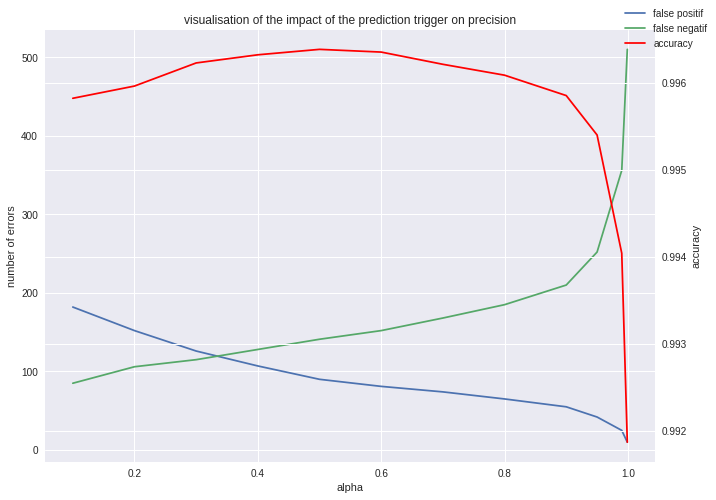

In [0]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10,7)
ax1.set_title('visualisation of the impact of the prediction trigger on precision')
ax1.set_xlabel('alpha')
ax1.set_ylabel('number of errors')
ax1.plot(alpha, false_pos,label = 'false positif')
ax1.plot(alpha, false_neg, label = 'false negatif')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('accuracy')  # we already handled the x-label with ax1
ax2.plot(alpha, score, label = 'accuracy', color = 'red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend()
plt.show()



So as planned, when we increase alpha, we make less good prediction to 1, so our rate of false negative increase. In the same time, we make less mistake on the 1 we label. 
We can see that until an alpha of 0.8, this trade off have a small impact on the overall accuracy thus we can keep same precision level and guarantiing less mistake on prediction labels 1. 

We can then combine this approach with the graph approach to reduce the number of mistakes coming from the false negatif !

**Lets make the prediction for the validation set with this approach**

In [0]:
df_test = pd.DataFrame()
df_test['graph'] = y
df_test['soft'] = y_soft

In [0]:
#This function make the prediction as describe above, between the graph and the NN
def predict(a,y_soft,yy):
    if yy == 1:
        return 1
    else:
        if y_soft > a:
            return 1
        else:
            return 0

predict = np.vectorize(predict)

#As discussed previously, we will use a alpha factor of 0.8 to guaranty best
#trade off for use between false negatif and global accuracy
yp = predict(0.8,df_test.soft.values,df_test.graph.values)

In [0]:
np.savetxt('mix_NN_graph.csv', yp, fmt = '%1.0d', delimiter=',')

This is what I used in my last submission. By doing this I managed to reach an accuracy of 0.9990 on the hidden test set.

### Why this method is not relevant

In real-life condition, the algorithm will have to make decisions on on a lot of images and in particular :
- Some images from people already in the database, but from new angles, that implies new set of features f1 to f14
- Some images from completly new people from who we don't have a graph.

For both these cases, we will not be able with this method to make a prediction : the algorithm will always predict 0.

![Texte alternatif…](https://i.imgur.com/EpvHX50.png)

![Texte alternatif…](https://i.imgur.com/l3bItZj.png)

And this is exactly what we want to avoid : in long term usage the prediction rate will tend to the predictor that always label data to 0 !

**Thus, and dispite it is giving from far the best score, I really don't like the graph approach.**

And this is true also for any other classification algorithm : we need to make sure that it performs well for any new picture that might come in the set. Because these algorithms could eventually detect also this innerent paterns we discorered using the graph. 

So when training and evaluating our models, the true good approach shall be to make the evaluation on a training set where some lines comes from different pictures compare to the training set.

In the last part of this report, I will just evaluate again the different algorithm I tryied here, but this time, splitting correctly the data to have only new images in the test set.

# Splitting the dataset in a smarter way

To split correctly the data, we prepare a list of all unique labels we got from the graph method.

We will make the split on 'A' to guaranty new images on our test set

In [6]:
xtrain['A'] = df['A']
xtrain.head()

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB14,s1,s2,s3,s4,s5,s6,s7,s8,A
0,3.77,1.00,1.0,41,1.0,0.0,0.0,-0.17,0.03,0.00,...,271.80,2464.1,2117.2,1760.6,2241.3,1900.3,1462.8,2344.9,1949.8,0
1,1.47,0.01,0.0,62,1.0,0.0,0.0,0.30,0.02,-0.01,...,157.15,3975.9,2640.9,2672.6,4233.8,3357.9,2224.0,3341.1,3611.5,1
2,4.93,1.00,0.0,21,1.0,0.0,0.0,0.00,0.16,0.00,...,283.33,3401.1,2644.3,2514.2,3551.3,3019.7,3414.7,2763.6,3252.2,2
3,3.89,1.00,0.0,20,1.0,0.0,0.0,-0.35,0.09,-0.01,...,298.40,2418.6,2659.6,2742.1,3422.4,2602.6,2784.0,2697.4,2505.1,3
4,3.15,0.00,0.0,28,1.0,0.0,0.0,0.08,-0.08,-0.01,...,248.69,2309.1,2164.0,1755.6,2377.4,1994.6,2147.6,1902.9,2599.5,4


In [7]:
#We create the list of unique element of fA
fA_list = xtrain.A.unique()
print(fA_list)

#We shuffle this list
fA_list = shuffle(fA_list)
print(fA_list)

#We define a 95% / 5% split on the list
split = 0.95
train_fA = fA_list[:int(np.floor(split*len(fA_list)))]

#We now make train and test set using the elements in train_fA:
ind_train = xtrain[xtrain.A.isin(train_fA)].index
ind_test =  xtrain[~xtrain.A.isin(train_fA)].index

Xtrain, Ytrain = xtrain.loc[ind_train], ytrain[ind_train]
Xtest, Ytest = xtrain.loc[ind_test], ytrain[ind_test]

print(f'num of element in Xtrain : {len(Xtrain)}')
print(f'num of element in Xtest : {len(Xtest)}')
      
print(f'num of element in Ytrain : {len(Ytrain)}')
print(f'num of element in Ytest : {len(Ytest)}')

[    0     1     2 ... 81247 81248 81249]
[51229 25110 74762 ... 38312 66554 78596]
num of element in Xtrain : 3037373
num of element in Xtest : 159092
num of element in Ytrain : 3037373
num of element in Ytest : 159092


Now we have the guaranty that we will evaluate the perfomances of the different algorithms on a test set with 'never seen before' pictures ! :) 

### Evaluation of the LGBM algorithm with this split

In [16]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(num_leaves = 1000, 
                     n_estimators = 500, 
                     learning_rate = 0.05).fit(Xtrain, Ytrain)
score_lgb = lgb.score(Xtest,Ytest)

print(f'score of the lgb model : {round(score_lgb,4)}')

score of the lgb model : 0.9887


Normalized confusion matrix
[[0.9876 0.0124]
 [0.0082 0.9918]]


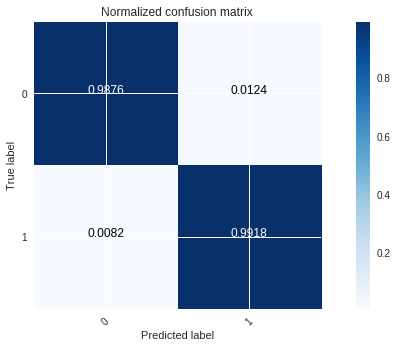

In [17]:
from sklearn.metrics import confusion_matrix
import itertools
# Compute confusion matrix
cnf_matrix = confusion_matrix(lgb.predict(Xtest), Ytest)
np.set_printoptions(precision=4)

plt.figure(figsize = (10,5))
plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

We see here that when we split the data, the LGBM, tuned same way as before, is performing less well with good fA-split compare to random split.

Both False Positive and False Negative rate have increased

### Evaluating of the NN (on model 5b)

In [0]:
x_ = pd.concat([Xtrain,Xtest])
ntrain = len(Xtrain)


#This time we rescale only features scores and fA14 and fB14
for i in ['s'+str(i) for i in range(1,9)]:
    x_[i] = rank_gauss(x_[i].values)

x_['fA14'] = rank_gauss(x_['fA14'].values)
x_['fB14'] = rank_gauss(x_['fB14'].values)

oheA = OneHotEncoder(categories='auto')
oheB = OneHotEncoder(categories='auto')

#We generate the list of features to be ohe
list_featsA = ['fA'+str(i) for i in range(1,14)]
list_featsB = ['fB'+str(i) for i in range(1,14)]

#We first split train and set, and we then ohe both of them
_Xtrain= x_[:ntrain]
_Xtest = x_[ntrain:]

oheA.fit(x_[list_featsA])
oheB.fit(x_[list_featsB])


Xtrain_oheA = oheA.transform(_Xtrain[list_featsA])
Xtest_oheA = oheA.transform(_Xtest[list_featsA])

Xtrain_oheB = oheB.transform(_Xtrain[list_featsB])
Xtest_oheB = oheB.transform(_Xtest[list_featsB])

Xtrain_14A = _Xtrain[['fA14']]
Xtest_14A = _Xtest[['fA14']]

Xtrain_14B = _Xtrain[['fB14']]
Xtest_14B = _Xtest[['fB14']]

Xtrain_s = _Xtrain[['s'+str(i) for i in range(1,9)]]
Xtest_s = _Xtest[['s'+str(i) for i in range(1,9)]]

In [0]:
# We create the tensors for the input
inputs_oheA = Input(shape=(Xtrain_oheA.shape[1],), name = 'OheA_inputs')
inputs_oheB = Input(shape=(Xtrain_oheB.shape[1],), name = 'OheB_inputs')
inputs_14A = Input(shape=(1,), name = '14A_inputs')
inputs_14B = Input(shape=(1,), name = '14B_inputs')
input_score = Input(shape=(8,), name = 'Scores_inputs')

#List of both inputs for the concatenation and compilation 
input_list = [inputs_oheA,
              inputs_oheB,
              inputs_14A,
              inputs_14B,
              input_score]

#Concatenation of the inputs of both images
imgA = concatenate([inputs_oheA,inputs_14A], name='Img_mergeA')
imgB = concatenate([inputs_oheB,inputs_14B], name='Img_mergeB')

#We train two layers, one for each image:
sA = concatenate([imgA,input_score], name='conc_scoreA')
sB = concatenate([imgB,input_score], name='conc_scoreB')

sA = Dense(1024, activation = 'relu',name = 'Dense_sA')(sA)
sB = Dense(1024, activation = 'relu',name = 'Dense_sB')(sB)


#We concatenate now all 8 layers
xc = concatenate([sA,sB], name = 'all_scores')
xc = Dense(128, activation = 'relu', name = f'Score_Dense')(xc)
predictions = Dense(1, activation='sigmoid',name = 'Sigmoid')(xc)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=input_list, outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Xtrain_inputs = [Xtrain_oheA,
                 Xtrain_oheB,
                 Xtrain_14A,
                 Xtrain_14B] \
                + [Xtrain_s]

Xtest_inputs = [Xtest_oheA,
                 Xtest_oheB,
                 Xtest_14A,
                 Xtest_14B] \
                + [Xtest_s]
model.fit(Xtrain_inputs, Ytrain, epochs=10, batch_size=4096, validation_data=(Xtest_inputs, Ytest), callbacks=[history])

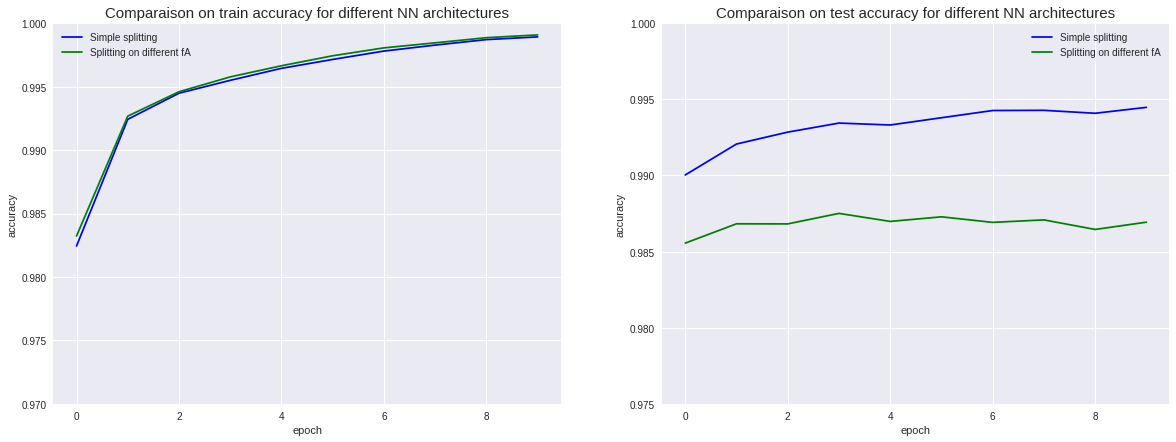

In [11]:
model5bbis = pd.DataFrame(history.history)
model5b = pd.read_csv('model5b.csv')

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.title('Comparaison on train accuracy for different NN architectures',size=15)
plt.plot(model5b['acc'],color = 'blue', label = 'Simple splitting')
plt.plot(model5bbis['acc'],color = 'green', label = 'Splitting on different fA')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.97,1])
plt.legend()


plt.subplot(1,2,2)
plt.title('Comparaison on test accuracy for different NN architectures',size=15)
plt.plot(model5b['val_acc'],color = 'blue', label = 'Simple splitting')
plt.plot(model5bbis['val_acc'],color = 'green', label = 'Splitting on different fA')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.975,1])
plt.legend()
plt.show()

We see that the training accuracy has the same behaviour depending on the way we split the data. This is logic because there is no change in the organization of data here.

Where it becomes interesting, is to see that the model is really out-performing with a better split than before : going from 0.995 without working the train-test split to 0.987 when working on it.

# Conclusion

We tested in this Challenge 3 main methods to improve our score :
1 ) The boosting methods, that are well known to perform well on structured data like the one we have
2 ) The Neural networks, that, turned in a custom architecture was performing better than the boosting
3 ) The graphs of similarity, that is exploiting the fact that same set of picture is used in both train and test set.

In the best, by combaning the accuracy of our NN and the 0% false positif rate of the graph, we manage to reach a score of 0.999, which is amazing.

Nevertheless, this score doesn't reflect what should be done in a industrial case. In fact, considering the real world, new pictures will feed our algorithm all the time, and to evaluate it properly, we shall take that into account when we split our train and test data. By doing so, we make sure that it will stay consistant during real use.

When using this approach, the graph method becomes completly irrelevant as it will always predict 0 as new pictures are never connected to any of our graphes.

**More surprisingly, it turned out that our best Neural Network model, that was performing up to 0.9969, is performing less well than the LGBM algorithm that we tuned quickly when it dealed with fA-splitted data (0.989 for LGBM vs 0.987 for the NN ), and I would probably improve and submit the LGBM for a real usage case **

My conclusion here is that as Data Scientist we shall always be carefull when evaluating a model. We might spend a lot of time optimizing a complex model that fit very well on our train and test set, but if we don't take a bit of distance about what we do, we can miss very important element that would completly change our approach from sketch.

Another thing that I didn't explored much but would have surely a impact in a real-life algorithm is the prediction time and the power consuption, but, not having any clues about the requierements here, I didn't look at it so much.